# Modelo de clasificación en SageMaker
## Contexto
Es importante que las empresas de tarjetas de crédito sean capaces de reconocer las transacciones fraudulentas con tarjetas de crédito para que no se cobre a los clientes por artículos que no han comprado.

## Contenido
El conjunto de datos contiene las transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeas.
Este conjunto de datos presenta transacciones ocurridas en dos días, donde tenemos 492 fraudes de 284.807 transacciones. El conjunto de datos está muy desequilibrado, la clase positiva (fraudes) representa el 0,172% de todas las transacciones.

Sólo contiene variables numéricas de entrada que son el resultado de una transformación PCA. Lamentablemente, por cuestiones de confidencialidad, no podemos proporcionar las características originales ni más información sobre los datos. Las características V1, V2, ... V28 son los componentes principales obtenidos con PCA, las únicas características que no han sido transformadas con PCA son 'Tiempo' y 'Cantidad'. La característica "Tiempo" contiene los segundos transcurridos entre cada transacción y la primera transacción del conjunto de datos. La característica "Importe" es el importe de la transacción; esta característica puede utilizarse para el aprendizaje sensible a los costes en función del ejemplo. La característica "Clase" es la variable de respuesta y toma el valor 1 en caso de fraude y 0 en caso contrario.

Esta base de datos se descargo desde el repositorio de kaggle, en donde pueden investigar más sobre el análisis y/o descargar la base de datos y trabajar por su cuenta en el mismo conjunto de datos en: https://www.kaggle.com/mlg-ulb/creditcardfraud

## Metodología
- Se realizará un análisis descriptivo de las variables de la base de datos.
- Se validará si existen correlaciones entre las variables.
- Se implementará un modelo de Regresión Logística.
- Se validará el modelo propuesto con algunas métricas de validación (matriz de confusión, accuracy, precision, recall y curva ROC).
- Se guardará el objeto del modelo en el Storage de S3.
- Se cargará el objeto guardado en el Storage de S3 y obtendremos las predicciones del conjunto de prueba.

In [1]:
# LIBRERIAS A UTILIZAR
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn import metrics
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import tempfile
import boto3
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# CARGA DE LA BASE DE DATOS
path_data = "s3:/s3-mguzman/bases-datos-pruebas/credit-card-fraud-detection/creditcard.csv"
card = pd.read_csv(path_data)

In [3]:
# INFORMACIÓN DE LA BASE DE DATOS
card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
# ANÁLISIS DESCRIPTIVO
card.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
card.shape

(284807, 31)

In [6]:
# DATOS FALTANTES POR COLUMNAS
card.isnull().sum()/len(card)

Time      0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Amount    0.0
Class     0.0
dtype: float64

In [7]:
# VALIDACIÓN DE REGISTROS DUPLICADOS
print(card.shape)
print(card.drop_duplicates().shape)
card = card.drop_duplicates()

(284807, 31)
(283726, 31)


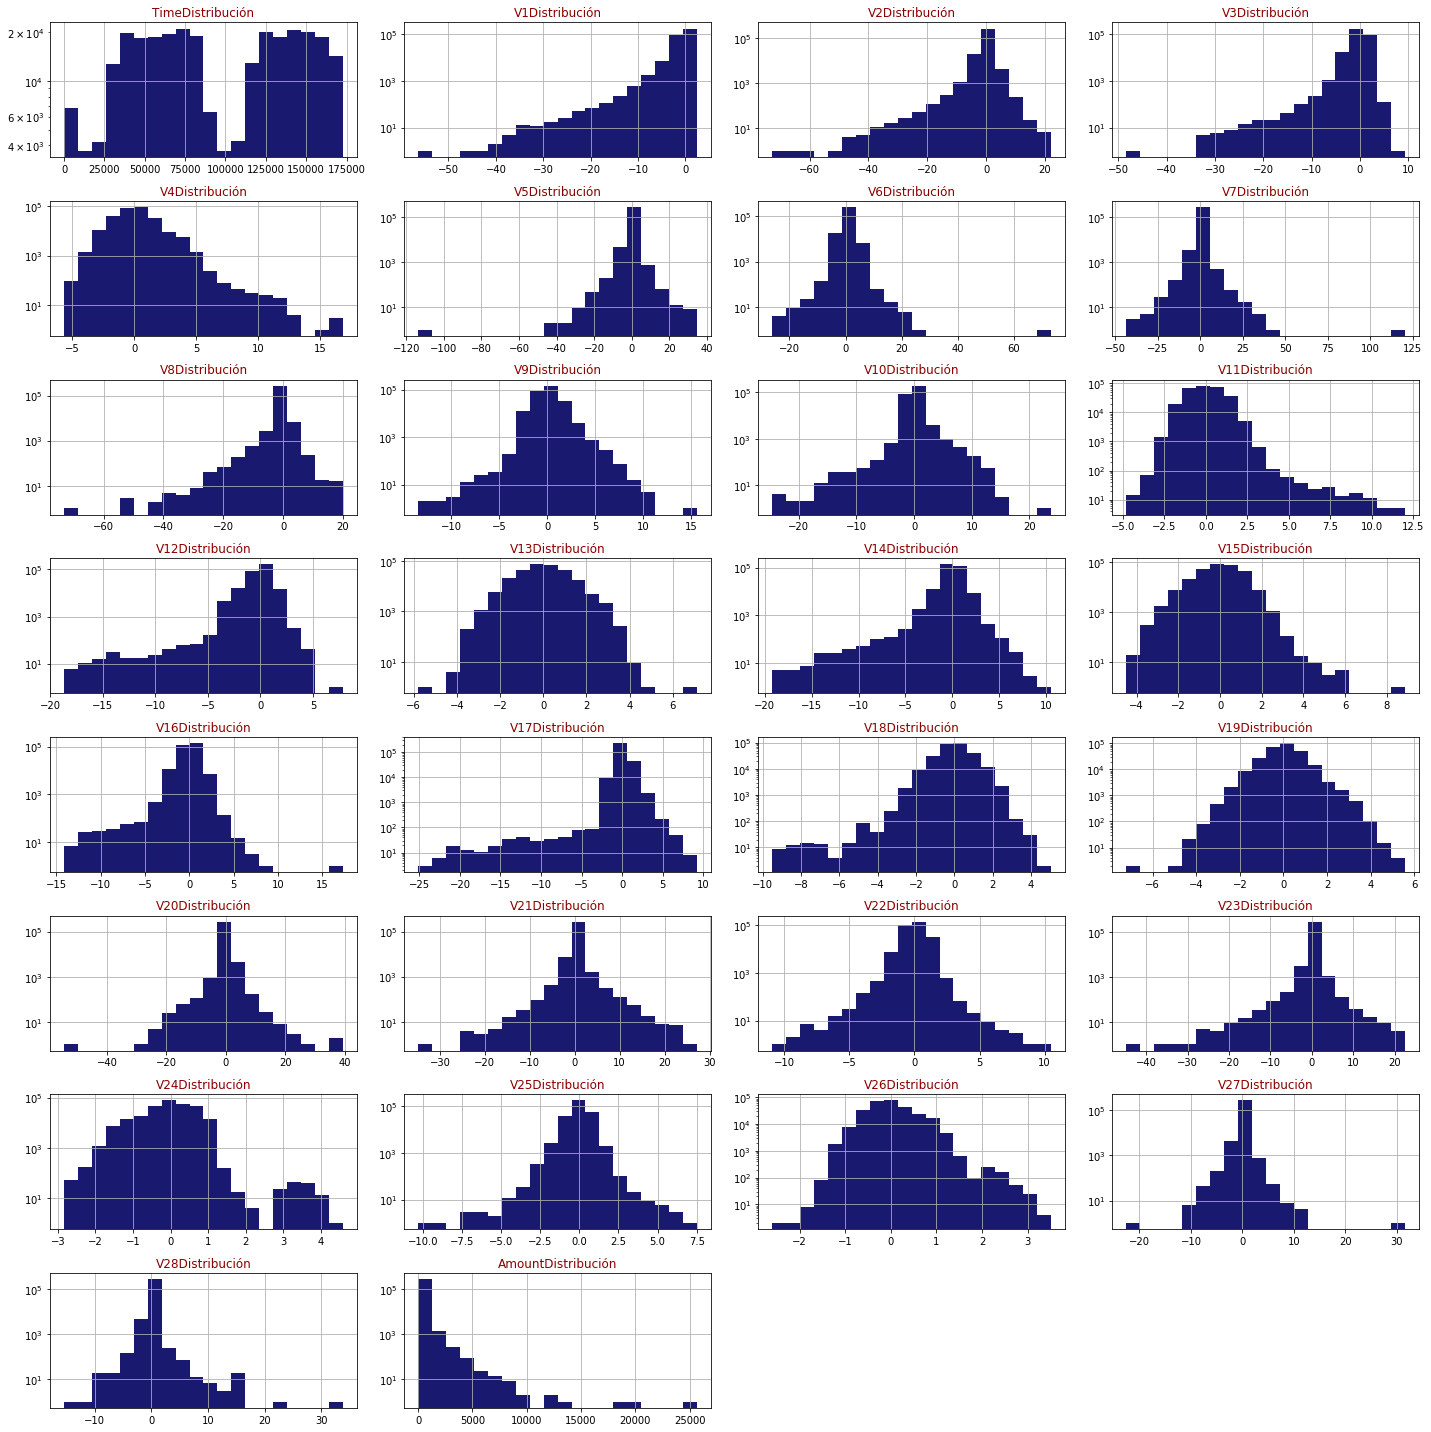

In [8]:
# DISTRIBUCIÓN DE CADA VARIABLE
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+"Distribución",color='DarkRed')
        ax.set_yscale('log')
    fig.tight_layout()  
    plt.show()
draw_histograms(card,card.columns[:-1],8,4)

In [9]:
# BALANCE DE VARIABLE RESPUESTA
card.Class.value_counts()

0    283253
1       473
Name: Class, dtype: int64

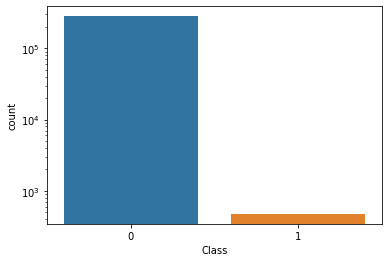

In [10]:
# BALANCE DE VARIABLE RESPUESTA
ax=sns.countplot(x='Class',data=card);
ax.set_yscale('log')

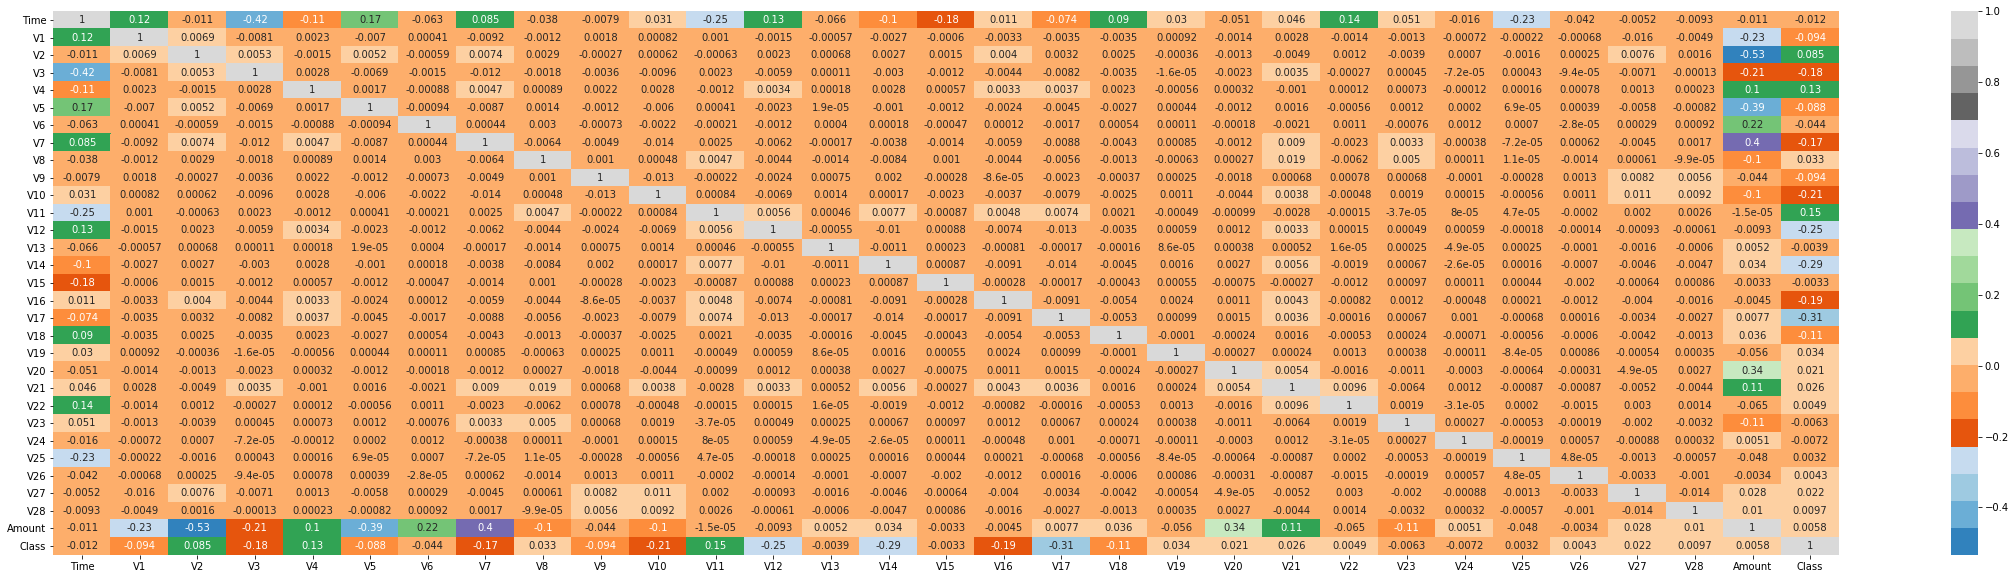

In [11]:
# MATRIZ DE CORRELACIONES
plt.figure(figsize = (40,10))
sns.heatmap(card.corr(), annot = True, cmap="tab20c")
plt.show()

In [12]:
corr_card = abs(card.corr())

In [13]:
corr_card

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,0.117927,0.010556,0.422054,0.105845,0.173223,0.063279,0.085335,0.038203,0.007861,0.031068,0.248536,0.125500,0.065958,0.100316,0.184392,0.011286,0.073819,0.090305,0.029537,0.051022,0.045913,0.143727,0.051474,0.015954,0.233262,0.041818,0.005171,0.009305,0.010559,0.012359
V1,0.117927,1.000000,0.006875,0.008112,0.002257,0.007036,0.000413,0.009173,0.001168,0.001828,0.000815,0.001028,0.001524,0.000568,0.002663,0.000602,0.003345,0.003491,0.003535,0.000919,0.001393,0.002818,0.001436,0.001330,0.000723,0.000222,0.000684,0.015706,0.004861,0.230105,0.094486
V2,0.010556,0.006875,1.000000,0.005278,0.001495,0.005210,0.000594,0.007425,0.002899,0.000274,0.000620,0.000633,0.002266,0.000680,0.002711,0.001538,0.004013,0.003244,0.002477,0.000358,0.001287,0.004897,0.001237,0.003855,0.000701,0.001569,0.000253,0.007555,0.001611,0.533428,0.084624
V3,0.422054,0.008112,0.005278,1.000000,0.002829,0.006879,0.001511,0.011721,0.001815,0.003579,0.009632,0.002339,0.005900,0.000113,0.003027,0.001230,0.004430,0.008159,0.003495,0.000016,0.002269,0.003500,0.000275,0.000449,0.000072,0.000425,0.000094,0.007051,0.000134,0.212410,0.182322
V4,0.105845,0.002257,0.001495,0.002829,1.000000,0.001744,0.000880,0.004657,0.000890,0.002154,0.002753,0.001223,0.003366,0.000177,0.002801,0.000572,0.003346,0.003655,0.002325,0.000560,0.000318,0.001034,0.000115,0.000732,0.000120,0.000162,0.000777,0.001322,0.000231,0.099514,0.129326
V5,0.173223,0.007036,0.005210,0.006879,0.001744,1.000000,0.000938,0.008709,0.001430,0.001213,0.006050,0.000411,0.002342,0.000019,0.001000,0.001171,0.002373,0.004466,0.002685,0.000436,0.001185,0.001622,0.000559,0.001183,0.000198,0.000069,0.000390,0.005798,0.000820,0.387685,0.087812
V6,0.063279,0.000413,0.000594,0.001511,0.000880,0.000938,1.000000,0.000436,0.003036,0.000734,0.002180,0.000211,0.001185,0.000397,0.000184,0.000470,0.000122,0.001716,0.000541,0.000106,0.000181,0.002134,0.001104,0.000755,0.001202,0.000697,0.000028,0.000289,0.000925,0.216389,0.043915
V7,0.085335,0.009173,0.007425,0.011721,0.004657,0.008709,0.000436,1.000000,0.006419,0.004921,0.013617,0.002454,0.006153,0.000170,0.003816,0.001394,0.005944,0.008794,0.004279,0.000846,0.001192,0.009010,0.002280,0.003303,0.000384,0.000072,0.000624,0.004537,0.001657,0.400408,0.172347
V8,0.038203,0.001168,0.002899,0.001815,0.000890,0.001430,0.003036,0.006419,1.000000,0.001038,0.000481,0.004688,0.004414,0.001381,0.008387,0.001044,0.004376,0.005576,0.001323,0.000626,0.000271,0.018892,0.006156,0.004994,0.000113,0.000011,0.001407,0.000613,0.000099,0.104662,0.033068
V9,0.007861,0.001828,0.000274,0.003579,0.002154,0.001213,0.000734,0.004921,0.001038,1.000000,0.012613,0.000217,0.002385,0.000745,0.001981,0.000283,0.000086,0.002318,0.000373,0.000247,0.001838,0.000679,0.000785,0.000677,0.000103,0.000275,0.001253,0.008221,0.005591,0.044123,0.094021


In [14]:
# REVISIÓN DE LA CORRELACIÓN POR VARIABLE
for i in range(corr_card.shape[0]):
    print("Variable: {0}".format(corr_card.columns[i]))
    if sum(corr_card.iloc[i]<=0.7)<30:
        print("Presenta variable correlacionada")
    else:
        print("Ok")

Variable: Time
Ok
Variable: V1
Ok
Variable: V2
Ok
Variable: V3
Ok
Variable: V4
Ok
Variable: V5
Ok
Variable: V6
Ok
Variable: V7
Ok
Variable: V8
Ok
Variable: V9
Ok
Variable: V10
Ok
Variable: V11
Ok
Variable: V12
Ok
Variable: V13
Ok
Variable: V14
Ok
Variable: V15
Ok
Variable: V16
Ok
Variable: V17
Ok
Variable: V18
Ok
Variable: V19
Ok
Variable: V20
Ok
Variable: V21
Ok
Variable: V22
Ok
Variable: V23
Ok
Variable: V24
Ok
Variable: V25
Ok
Variable: V26
Ok
Variable: V27
Ok
Variable: V28
Ok
Variable: Amount
Ok
Variable: Class
Ok


In [15]:
# SEPARAMOS EL CONJUNTO DE ENTRENAMIENTO Y PRUEBA
x = card[card.columns[:-1]]
y = card[card.columns[-1]]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.3,stratify=y)

In [16]:
# CONJUNTO DE ENTRENAMIENTO
print("Conjunto de entrenamiento")
print(x_train.shape)
print(y_train.shape)
print("Cantidad de casos favorables")
print(sum(y_train))
print("Tasa de casos favorables")
print(round(sum(y_train)/y_train.count(),6))
# CONJUNTO DE PRUEBA
print("Conjunto de prueba")
print(x_test.shape)
print(y_test.shape)
print("Cantidad de casos favorables")
print(sum(y_test))
print("Tasa de casos favorables")
print(round(sum(y_test)/y_test.count(),6))

Conjunto de entrenamiento
(198608, 30)
(198608,)
Cantidad de casos favorables
331
Tasa de casos favorables
0.001667
Conjunto de prueba
(85118, 30)
(85118,)
Cantidad de casos favorables
142
Tasa de casos favorables
0.001668


In [17]:
# PARÁMETROS POR DEFECTO
lr = LogisticRegression()
# fit the model with data
lr.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
y_pred=lr.predict(x_test)

In [19]:
# MATRIZ DE CONFUSIÓN
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[84938,    38],
       [   55,    87]])

Text(0.5, 15.0, 'Predicted label')

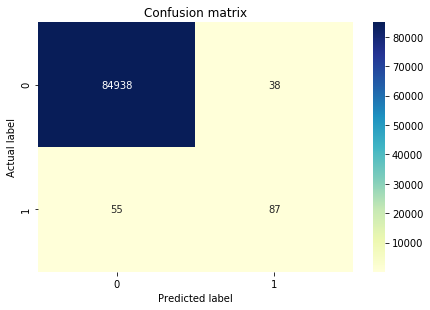

In [20]:
# MAPA DE CALOR DE LA MATRIZ DE CONFUSIÓN
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [21]:
# MÉTRICAS DE EVALUACIÓN DEL MODELO
print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred),4))
print("Precision:", round(metrics.precision_score(y_test, y_pred),4))
print("Recall:", round(metrics.recall_score(y_test, y_pred),4))

Accuracy: 0.9989
Precision: 0.696
Recall: 0.6127


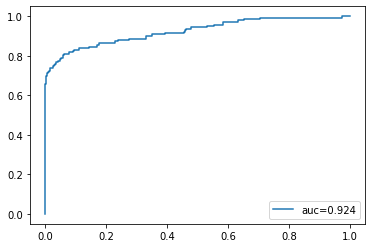

In [22]:

y_pred_proba = lr.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = round(metrics.roc_auc_score(y_test, y_pred_proba),4)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [33]:
today = datetime.today().date().strftime("%Y-%m-%d")
# ESCRIBIR EL MODELO EN S3
s3 = boto3.client('s3')
bucket = "s3-mguzman"
key = "bases-datos-pruebas/credit-card-fraud-detection/model/{0}/model.joblib".format(today)
with tempfile.TemporaryFile() as fp:
    joblib.dump(lr, fp)
    fp.seek(0)
    s3.put_object(Body=fp.read(), Bucket=bucket, Key=key)
    
# CARGAR EL MODELO
with tempfile.TemporaryFile() as fp:
    s3.download_fileobj(Fileobj=fp, Bucket=bucket, Key=key)
    fp.seek(0)
    model = joblib.load(fp)
    
# ELIMINAR OBJETOS DE S3
# s3_resource.delete_object(Bucket=bucket_str, Key=bucket_key)

# GUARDAR EN EL LOCAL
# joblib.dump(lr,'/root/webinar/model.joblib')

# CARGAR MODELO DEL LOCAL
# model = joblib.load('/root/webinar/model.joblib')

In [24]:
# Calculate the accuracy score and predict target values
score = model.predict(x_test)
cnf_matrix = metrics.confusion_matrix(y_test, score)
cnf_matrix

array([[84938,    38],
       [   55,    87]])

Text(0.5, 15.0, 'Etiqueta predicha')

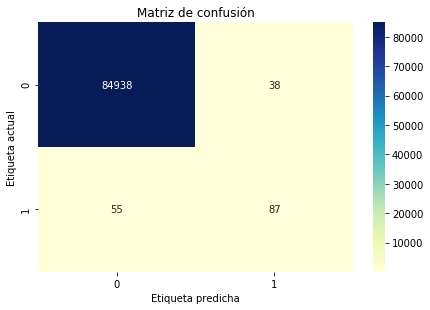

In [25]:
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Etiqueta actual')
plt.xlabel('Etiqueta predicha')